In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
np.random.RandomState(seed=1)
import pickle

In [16]:
# Будут использоваться 2 типа данных: 
                    # числовые + деление + текстовые признаки 
#                     числовые + деление

# каждый тип обучается на 2 моделях: catboost и LogRegression


In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
results = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', '2*roc_auc-1', 'thrs', 'predicted'])
def evaluation(model_name, val, predicted, thrs=0.5):
    '''
    На вход - имя модели и метки, получившиеся после обучения модели, и метки валидационной выборки
    Возвращает таблицу с результатами results
    '''
    
    acc = metrics.accuracy_score(val, (predicted>thrs))
    pr = metrics.precision_score(val, (predicted>thrs))
    rec = metrics.recall_score(val, (predicted>thrs))
    f1 = metrics.f1_score(val, (predicted>thrs))
    roc_auc = metrics.roc_auc_score(val, predicted)
    roc_norm = roc_auc * 2 - 1
    
    results.loc[len(results)] = [model_name, acc, pr, rec, f1, roc_auc, roc_norm, thrs, predicted]

    
def plot(model_name, predicted, val, thrs=0.5):
    '''
    Рисует для конкретной модели roc и предсказания
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(val, predicted)
    
    A = np.array(predicted)
    idx_sig = np.where(val == 1)[0]
    idx_bkg = np.where(val == 0)[0]
    bins = 10
    
    plt.figure(figsize=(12,4))
    ax1 = plt.subplot(1,2,1)
    plt.plot(fpr,  tpr, '.')
    plt.title(model_name)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
    ax2 = plt.subplot(1,2,2)
    plt.hist(A[idx_sig], histtype='step', label='1', density=True, bins = bins)
    plt.hist(A[idx_bkg], histtype='step', label='0', density=True, bins = bins)
    plt.vlines(x=thrs, ymin=0, ymax=4, color='red', linestyle='--', label = 'threshold')
    plt.xlabel('prediction')
    plt.xticks((0.0, 0.2, 0.4, 0.6, 0.8, 1.0), color='k', size=14)
    plt.legend(loc="upper right")
    plt.title(model_name)
    plt.show()
    plt.close('all') 


In [19]:
def models(model_feature, x_train, y_train, x_val, y_val, thrs=0.5):
    '''
    Функция осуществляет RandomGridSearch для моделей catboost и LogRegr. Модель переобучается на лучших параметрах, 
    результаты валидации добавляются в таблицу results с помощью evaluation()
    '''
    print('---Random---')
    #1. Catboost
    print('---Catboost---')
    model = CatBoostClassifier(silent=True)
    param_grid = {'objective' : ('Logloss', 'CrossEntropy'),
                  'iterations' : (100, 300, 500, 700, 1000),
                  'eta' : (1e-3, 1e-4, 1e-2),
                  'max_depth' : (2, 5, 7, 10, 12, 16),
                  'grow_policy' : ('SymmetricTree', 'Depthwise', 'Lossguide'),
                  'reg_lambda' : (1, 3, 5)
                 }
#     grid = GridSearchCV(model, param_grid, scoring='roc_auc', refit=True)
    grid = RandomizedSearchCV(model, param_grid, n_iter = 20, scoring='roc_auc', refit=True,  verbose=2, cv=3)
    grid.fit(x_train, y_train)
    preds_proba = grid.predict_proba(x_val)
    preds_proba1 = preds_proba[:, 1]
    evaluation(model_feature + '_catboost_', y_val, preds_proba1, thrs)
    print("Catboost: {}, {}".format(grid.best_params_, grid.best_score_))
    pickle.dump(grid, open(model_feature + '_catboost.pkl' , 'wb'))
    pickle.dump(grid.best_params_, open(model_feature + 'params_catboost.pkl' , 'wb'))
    
    #3. Logistic regression
    print('---Logistic regression---')
    model = LogisticRegression()
    param_grid = {'penalty' : ('l1', 'l2', 'elasticnet', None), 
                  'dual' : (True, False),
                  'tol' : (1e-4, 1e-5, 1e-3),
                  'C' : (0.5, 1, 2),
                  'fit_intercept' : (True, False),
                  'intercept_scaling' : (0.5, 1),
                  'class_weight' : ('balanced', None),
                  'solver' : ('liblinear', 'newton-cg', 'sag', 'saga'),
                  'max_iter' : (100, 300, 500, 700, 1000, 1500),
                  'warm_start' : (True, False),
                  'l1_ratio' : (0.3, 0.5, 0.7)
                 }
#     grid = GridSearchCV(model, param_grid, scoring='roc_auc', refit=True)
    grid = RandomizedSearchCV(model, param_grid, n_iter = 50, scoring='roc_auc', refit=True, verbose=2, cv=3)
    grid.fit(x_train, y_train)
    preds_proba = grid.predict_proba(x_val)
    preds_proba1 = preds_proba[:, 1]
    evaluation(model_feature + '_LogisticRegr', y_val, preds_proba1, thrs) 
    print("LogReg: {}, {}".format(grid.best_params_,   grid.best_score_))
    pickle.dump(grid, open(model_feature + '_LogisticRegr.pkl' , 'wb'))
    pickle.dump(grid.best_params_, open(model_feature + 'params_LogisticRegr.pkl' , 'wb'))
# loaded_model = pickle.load(open(filename, 'rb'))

In [20]:
def plot_results():
    '''
    Рисует для всех моделей из results roc и предсказания
    '''
    preds = results.predicted.values
    name = results.model.values
    thrs = results.thrs.values
    for i in range(len(results)):
        plot(str(i) + ':' + name[i], preds[i], y_val, thrs[i])

# 1. Числовые признаки + их деление друг на друга 

In [21]:
data = pd.read_csv('/Users/nzaretski/Desktop/education/wildberies/script/wb_school/data/data_analysis.csv')
data = data[data.duplicated() == False].reset_index(drop=True)
data.drop(['id1', 'id2', 'id3'], axis=1, inplace=True)

data_in = data.copy()

cols = list(data.columns)
cols.remove('label')
cols.remove('text')
print(cols)


# Добавление деления
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        if len(data[cols[j]][data[cols[j]]==0].values) == 0:
            name = 'div_' + cols[i] + '_' + cols[j]
            data[name] = data[cols[i]] / data[cols[j]]
            
data1 = data.copy()

['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8']


In [22]:
df_train, df_test = train_test_split(
    data,
    test_size=0.3, 
    random_state=1,
    stratify=data.label
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5, 
    random_state=1,
    stratify=df_test.label
)
df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

In [13]:
#grid
X_train = df_train.drop(['label', 'text'], axis=1)
y_train = df_train.label
X_val = df_val.drop(['label', 'text'], axis=1)
y_val = df_val.label

models('num_div', X_train, y_train, X_val, y_val)

---Random---
---Catboost---
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END eta=0.0001, grow_policy=Depthwise, iterations=700, max_depth=5, objective=CrossEntropy, reg_lambda=1; total time=   2.2s
[CV] END eta=0.0001, grow_policy=Depthwise, iterations=700, max_depth=5, objective=CrossEntropy, reg_lambda=1; total time=   2.2s
[CV] END eta=0.0001, grow_policy=Depthwise, iterations=700, max_depth=5, objective=CrossEntropy, reg_lambda=1; total time=   2.0s
[CV] END eta=0.0001, grow_policy=Lossguide, iterations=700, max_depth=16, objective=CrossEntropy, reg_lambda=1; total time=   3.5s
[CV] END eta=0.0001, grow_policy=Lossguide, iterations=700, max_depth=16, objective=CrossEntropy, reg_lambda=1; total time=   3.6s
[CV] END eta=0.0001, grow_policy=Lossguide, iterations=700, max_depth=16, objective=CrossEntropy, reg_lambda=1; total time=   3.6s
[CV] END eta=0.001, grow_policy=Lossguide, iterations=1000, max_depth=16, objective=CrossEntropy, reg_lambda=5; total time=   5.

[CV] END C=1, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=0.5, max_iter=500, penalty=l2, solver=sag, tol=1e-05, warm_start=False; total time=   0.1s
[CV] END C=1, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=0.5, max_iter=500, penalty=l2, solver=sag, tol=1e-05, warm_start=False; total time=   0.1s
[CV] END C=1, class_weight=balanced, dual=False, fit_intercept=False, intercept_scaling=0.5, l1_ratio=0.5, max_iter=100, penalty=elasticnet, solver=sag, tol=0.0001, warm_start=True; total time=   0.0s
[CV] END C=1, class_weight=balanced, dual=False, fit_intercept=False, intercept_scaling=0.5, l1_ratio=0.5, max_iter=100, penalty=elasticnet, solver=sag, tol=0.0001, warm_start=True; total time=   0.0s
[CV] END C=1, class_weight=balanced, dual=False, fit_intercept=False, intercept_scaling=0.5, l1_ratio=0.5, max_iter=100, penalty=elasticnet, solver=sag, tol=0.0001, warm_start=True; total time=   0.0s
[CV] END C=1, class_weigh

[CV] END C=1, class_weight=None, dual=False, fit_intercept=False, intercept_scaling=1, l1_ratio=0.5, max_iter=700, penalty=l2, solver=newton-cg, tol=0.0001, warm_start=True; total time=   0.1s
[CV] END C=1, class_weight=balanced, dual=True, fit_intercept=False, intercept_scaling=0.5, l1_ratio=0.3, max_iter=1000, penalty=l2, solver=newton-cg, tol=1e-05, warm_start=False; total time=   0.0s
[CV] END C=1, class_weight=balanced, dual=True, fit_intercept=False, intercept_scaling=0.5, l1_ratio=0.3, max_iter=1000, penalty=l2, solver=newton-cg, tol=1e-05, warm_start=False; total time=   0.0s
[CV] END C=1, class_weight=balanced, dual=True, fit_intercept=False, intercept_scaling=0.5, l1_ratio=0.3, max_iter=1000, penalty=l2, solver=newton-cg, tol=1e-05, warm_start=False; total time=   0.0s
[CV] END C=0.5, class_weight=balanced, dual=False, fit_intercept=False, intercept_scaling=1, l1_ratio=0.5, max_iter=1500, penalty=None, solver=liblinear, tol=0.0001, warm_start=False; total time=   0.0s
[CV] EN

[CV] END C=2, class_weight=balanced, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=0.5, max_iter=300, penalty=l2, solver=saga, tol=0.001, warm_start=False; total time=   0.1s
[CV] END C=2, class_weight=balanced, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=0.5, max_iter=300, penalty=l2, solver=saga, tol=0.001, warm_start=False; total time=   0.1s
[CV] END C=2, class_weight=balanced, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=0.5, max_iter=300, penalty=l2, solver=saga, tol=0.001, warm_start=False; total time=   0.1s
[CV] END C=1, class_weight=balanced, dual=True, fit_intercept=False, intercept_scaling=0.5, l1_ratio=0.5, max_iter=100, penalty=l2, solver=newton-cg, tol=0.0001, warm_start=True; total time=   0.0s
[CV] END C=1, class_weight=balanced, dual=True, fit_intercept=False, intercept_scaling=0.5, l1_ratio=0.5, max_iter=100, penalty=l2, solver=newton-cg, tol=0.0001, warm_start=True; total time=   0.0s
[CV] END C=1, class_weight=bala

# 2. Числовые признаки с делением + текст

In [34]:
data = data1.copy()

In [35]:
data.head(2)

,text,f1,f2,f3,f4,f5,f6,f7,f8,label,...,div_f2_f8,div_f3_f4,div_f3_f6,div_f3_f8,div_f4_f6,div_f4_f8,div_f5_f6,div_f5_f8,div_f6_f8,div_f7_f8
0,"Хотела купить на замену старых,по итогу эти у...",1,1,1.0,11,13,4.272727,18,36,0,...,0.027778,0.090909,0.234043,0.027778,2.574468,0.305556,3.042553,0.361111,0.118687,0.500000
1,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.7,46,4,4.434783,90,109,1,...,0.055046,0.058696,0.608824,0.024771,10.372549,0.422018,0.901961,0.036697,0.040686,0.825688


In [36]:
# количество знаков препинания
data['num_points'] = data.text.apply(lambda x: x.count(',') + x.count(';') \
                                   + x.count(':')+ x.count('.')+ x.count('!')+ x.count('?')\
                                   + x.count('"')+ x.count("'")+ x.count('/'))

In [37]:
# убираем знаки препинания и все, кроме русского текста
from string import digits, whitespace
import re

cyrillic_letters = "абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ"

def tokenizer(text):
    text = text.replace(',', ' ')
    text = text.replace(':', ' ')
    text = text.replace(';', ' ')
    text = text.replace('.', ' ')
    text = text.replace('!', ' ')
    text = text.replace('?', ' ')
    text = text.replace('"', ' ')
    text = text.replace("'", ' ')
    text = text.replace('/', ' ')
    allowed_chars = cyrillic_letters + digits + whitespace
    return re.sub("\s\s+", " ", "".join([c for c in text if c in allowed_chars])).strip()

# data.text = data.text.apply(lambda x: tokenizer(x.lower()))
data.text = data.text.apply(lambda x: tokenizer(x))

In [38]:
#количество слов, начинающихся с большой буквы
def big_letter(x):
    counter = 0
    for word in x.split():
        if word[0].upper() == word[0]:
            counter+=1
    return counter

data['num_big_letters'] = data.text.apply(lambda x: big_letter(x))
data.text = data.text.apply(lambda x: x.lower())

In [39]:
# средняя длина слова, количество слов
def avg_word_len(x): # x - string
    x = x.split()
    lens = []
    if len(x) == 0:
        return 0
    for i in x:
        lens.append(len(i))
    return np.mean(lens)

data['avg_word_len'] = data.text.apply(avg_word_len)
data['num_words'] = data.text.apply(lambda x: len(x.split()))

In [40]:
data['avg_big_letters'] = data.num_big_letters / data.num_words
data['avg_points'] = data.num_points / data.num_words

In [42]:
# заполняем нулями NaN
data = data.fillna(0)

In [43]:
data2 = data.copy()

In [29]:
data.shape

(3122, 34)

In [30]:
df_train, df_test = train_test_split(
    data,
    test_size=0.3, 
    random_state=1,
    stratify=data.label
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5, 
    random_state=1,
    stratify=df_test.label
)
df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

In [31]:
X_train = df_train.drop(['label', 'text'], axis=1)
y_train = df_train.label
X_val = df_val.drop(['label', 'text'], axis=1)
y_val = df_val.label

models('num_div_text', X_train, y_train, X_val, y_val)

---Random---
---Catboost---
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END eta=0.001, grow_policy=SymmetricTree, iterations=100, max_depth=16, objective=Logloss, reg_lambda=1; total time= 1.3min
[CV] END eta=0.001, grow_policy=SymmetricTree, iterations=100, max_depth=16, objective=Logloss, reg_lambda=1; total time= 1.3min
[CV] END eta=0.001, grow_policy=SymmetricTree, iterations=100, max_depth=16, objective=Logloss, reg_lambda=1; total time= 1.3min
[CV] END eta=0.0001, grow_policy=SymmetricTree, iterations=700, max_depth=16, objective=CrossEntropy, reg_lambda=5; total time= 9.1min
[CV] END eta=0.0001, grow_policy=SymmetricTree, iterations=700, max_depth=16, objective=CrossEntropy, reg_lambda=5; total time= 9.2min
[CV] END eta=0.0001, grow_policy=SymmetricTree, iterations=700, max_depth=16, objective=CrossEntropy, reg_lambda=5; total time= 9.2min
[CV] END eta=0.0001, grow_policy=Lossguide, iterations=700, max_depth=5, objective=CrossEntropy, reg_lambda=5; total ti

[CV] END C=2, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=0.5, l1_ratio=0.3, max_iter=500, penalty=l2, solver=newton-cg, tol=0.0001, warm_start=False; total time=   0.1s
[CV] END C=1, class_weight=None, dual=True, fit_intercept=False, intercept_scaling=0.5, l1_ratio=0.7, max_iter=1000, penalty=elasticnet, solver=saga, tol=1e-05, warm_start=False; total time=   0.0s
[CV] END C=1, class_weight=None, dual=True, fit_intercept=False, intercept_scaling=0.5, l1_ratio=0.7, max_iter=1000, penalty=elasticnet, solver=saga, tol=1e-05, warm_start=False; total time=   0.0s
[CV] END C=1, class_weight=None, dual=True, fit_intercept=False, intercept_scaling=0.5, l1_ratio=0.7, max_iter=1000, penalty=elasticnet, solver=saga, tol=1e-05, warm_start=False; total time=   0.0s
[CV] END C=1, class_weight=balanced, dual=True, fit_intercept=True, intercept_scaling=1, l1_ratio=0.3, max_iter=100, penalty=None, solver=saga, tol=0.001, warm_start=False; total time=   0.0s
[CV] END C=1, class

[CV] END C=1, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, l1_ratio=0.3, max_iter=1000, penalty=None, solver=sag, tol=1e-05, warm_start=False; total time=   0.0s
[CV] END C=1, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, l1_ratio=0.3, max_iter=1000, penalty=None, solver=sag, tol=1e-05, warm_start=False; total time=   0.0s
[CV] END C=1, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, l1_ratio=0.3, max_iter=1000, penalty=None, solver=sag, tol=1e-05, warm_start=False; total time=   0.0s
[CV] END C=1, class_weight=None, dual=False, fit_intercept=False, intercept_scaling=0.5, l1_ratio=0.5, max_iter=500, penalty=l1, solver=sag, tol=1e-05, warm_start=False; total time=   0.0s
[CV] END C=1, class_weight=None, dual=False, fit_intercept=False, intercept_scaling=0.5, l1_ratio=0.5, max_iter=500, penalty=l1, solver=sag, tol=1e-05, warm_start=False; total time=   0.0s
[CV] END C=1, class_weight=None, dual=False, fit_intercept

[CV] END C=1, class_weight=balanced, dual=False, fit_intercept=False, intercept_scaling=1, l1_ratio=0.7, max_iter=1000, penalty=l1, solver=liblinear, tol=0.001, warm_start=False; total time=   0.4s
[CV] END C=1, class_weight=balanced, dual=False, fit_intercept=False, intercept_scaling=1, l1_ratio=0.7, max_iter=1000, penalty=l1, solver=liblinear, tol=0.001, warm_start=False; total time=   1.1s
[CV] END C=1, class_weight=balanced, dual=False, fit_intercept=False, intercept_scaling=1, l1_ratio=0.7, max_iter=1000, penalty=l1, solver=liblinear, tol=0.001, warm_start=False; total time=   0.7s
[CV] END C=2, class_weight=None, dual=True, fit_intercept=False, intercept_scaling=0.5, l1_ratio=0.7, max_iter=1000, penalty=elasticnet, solver=liblinear, tol=1e-05, warm_start=True; total time=   0.0s
[CV] END C=2, class_weight=None, dual=True, fit_intercept=False, intercept_scaling=0.5, l1_ratio=0.7, max_iter=1000, penalty=elasticnet, solver=liblinear, tol=1e-05, warm_start=True; total time=   0.0s
[C

In [32]:
pickle.dump(results[results.thrs == 0.5], open('results.pkl' , 'wb'))

# Results

In [44]:
results = pickle.load(open('results.pkl', 'rb'))

In [45]:
results

,model,accuracy,precision,recall,f1,roc_auc,2*roc_auc-1,thrs,predicted
0,num_div_catboost_,0.805556,0.883721,0.306452,0.455090,0.769435,0.538869,0.5,"[0.20742166284881186, 0.16246444982828753, 0.1..."
1,num_div_LogisticRegr,0.732906,0.496644,0.596774,0.542125,0.767395,0.534790,0.5,"[0.3719450803355509, 0.1499199195547742, 0.447..."
2,num_div_text_catboost_,0.801282,0.878049,0.290323,0.436364,0.766059,0.532117,0.5,"[0.18881411824083566, 0.1412996638954845, 0.16..."
3,num_div_text_LogisticRegr,0.726496,0.486842,0.596774,0.536232,0.772154,0.544308,0.5,"[0.36042604353005303, 0.14547942743506279, 0.4..."


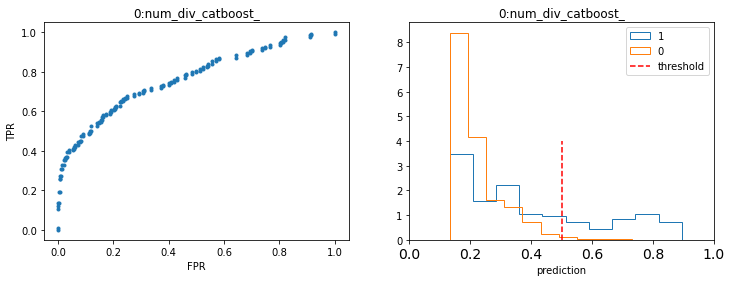

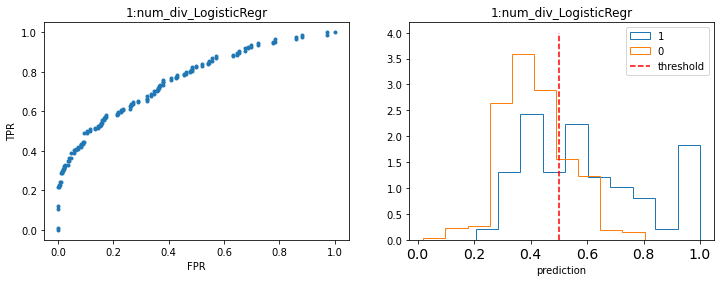

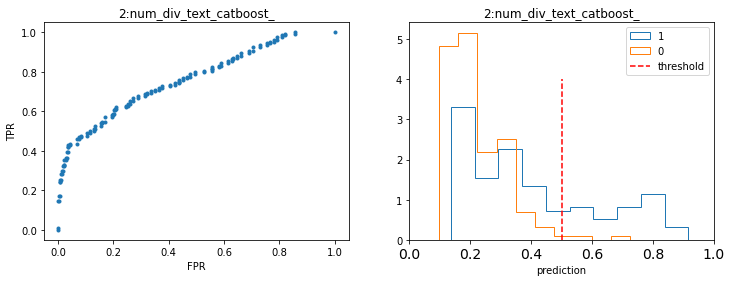

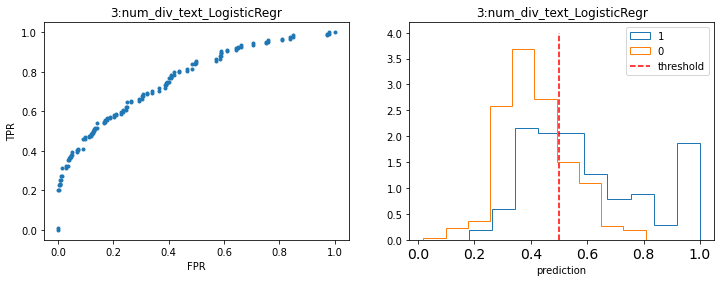

In [46]:
plot_results()

In [47]:
# проверка на валидации моделей с другим порогом
names = results.model.values
preds = results.predicted.values
thrs2=0.7

for i in range(len(results)):
    evaluation(names[i], y_val, preds[i], thrs2)
    if names[i] == 'num_div_catboost_':
        evaluation(names[i], y_val, preds[i], 0.4)

In [48]:
results

,model,accuracy,precision,recall,f1,roc_auc,2*roc_auc-1,thrs,predicted
0,num_div_catboost_,0.805556,0.883721,0.306452,0.455090,0.769435,0.538869,0.5,"[0.20742166284881186, 0.16246444982828753, 0.1..."
1,num_div_LogisticRegr,0.732906,0.496644,0.596774,0.542125,0.767395,0.534790,0.5,"[0.3719450803355509, 0.1499199195547742, 0.447..."
2,num_div_text_catboost_,0.801282,0.878049,0.290323,0.436364,0.766059,0.532117,0.5,"[0.18881411824083566, 0.1412996638954845, 0.16..."
3,num_div_text_LogisticRegr,0.726496,0.486842,0.596774,0.536232,0.772154,0.544308,0.5,"[0.36042604353005303, 0.14547942743506279, 0.4..."
4,num_div_catboost_,0.779915,0.956522,0.177419,0.299320,0.769435,0.538869,0.7,"[0.20742166284881186, 0.16246444982828753, 0.1..."
5,num_div_catboost_,0.809829,0.777778,0.395161,0.524064,0.769435,0.538869,0.4,"[0.20742166284881186, 0.16246444982828753, 0.1..."
6,num_div_LogisticRegr,0.801282,0.860465,0.298387,0.443114,0.767395,0.534790,0.7,"[0.3719450803355509, 0.1499199195547742, 0.447..."
7,num_div_text_catboost_,0.777778,0.954545,0.169355,0.287671,0.766059,0.532117,0.7,"[0.18881411824083566, 0.1412996638954845, 0.16..."
8,num_div_text_LogisticRegr,0.807692,0.886364,0.314516,0.464286,0.772154,0.544308,0.7,"[0.36042604353005303, 0.14547942743506279, 0.4..."


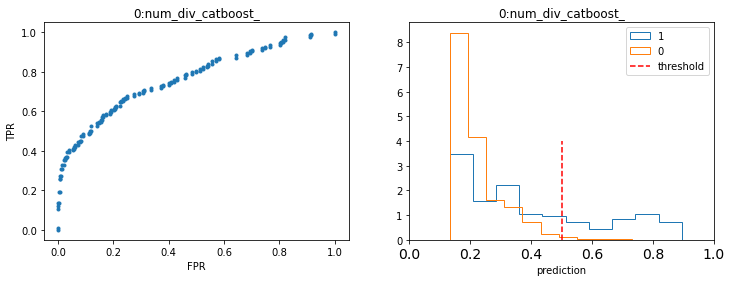

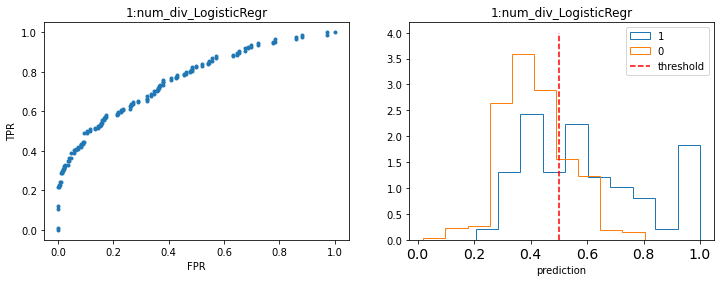

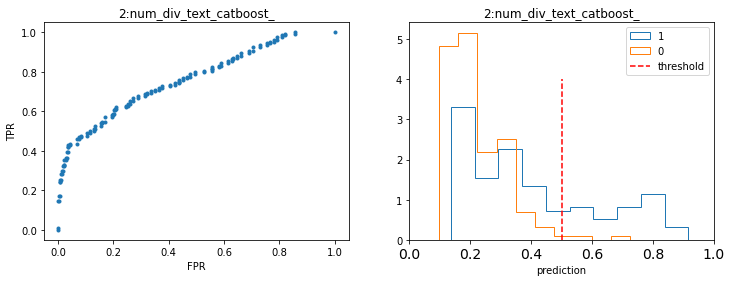

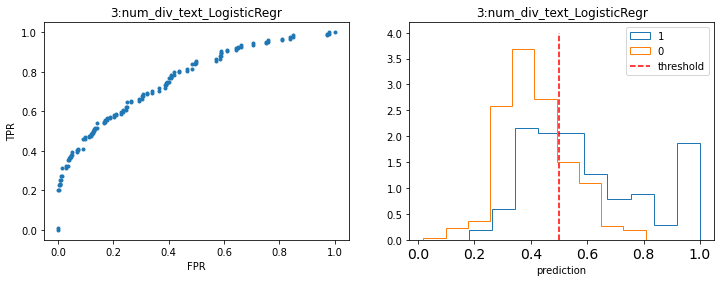

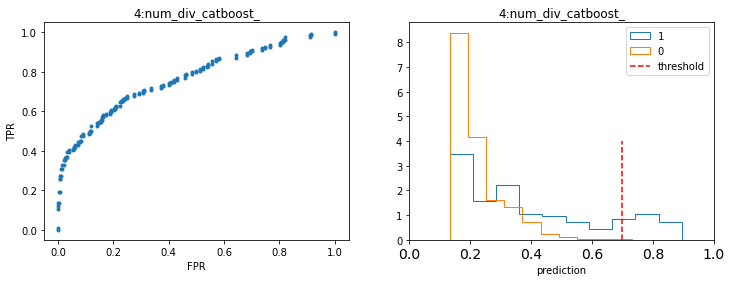

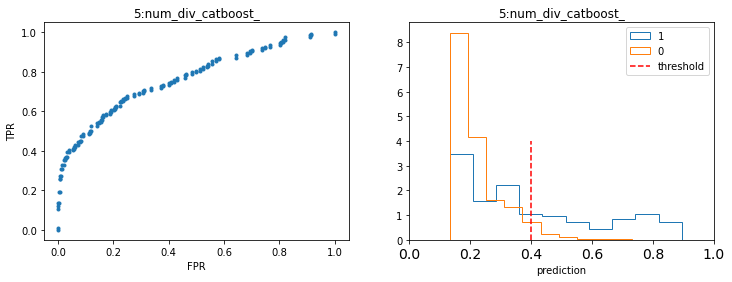

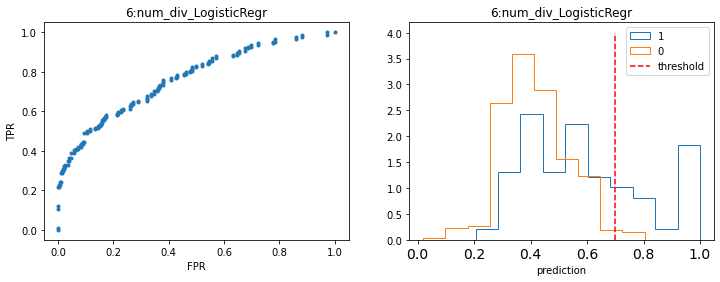

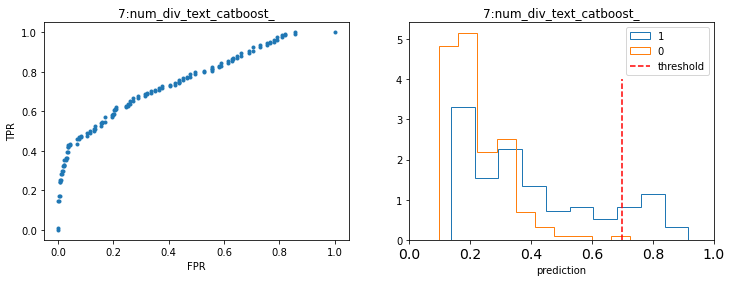

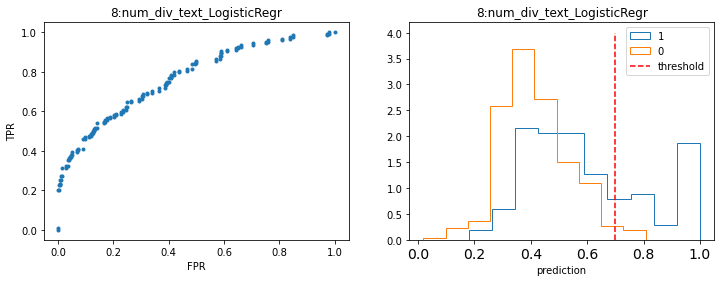

In [49]:
plot_results()

### выберем эти модели

num_div_LogisticRegr 0.7

num_div_text_LogisticRegr 0.7

num_div_text_catboost 0.5

num_div_catboost 0.4


# Проверка на тестовых данных!

## 1. num_div_LogisticRegr

In [51]:
data = data1.copy()
df_train, df_test = train_test_split(
    data,
    test_size=0.3, 
    random_state=1,
    stratify=data.label
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5, 
    random_state=1,
    stratify=df_test.label
)
df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)


X_train = df_train.drop(['label', 'text'], axis=1)
y_train = df_train.label
X_val = df_val.drop(['label', 'text'], axis=1)
y_val = df_val.label
X_test = df_test.drop(['label', 'text'], axis=1)
y_test = df_test.label

In [52]:
model = pickle.load(open('num_div_LogisticRegr.pkl', 'rb'))

evaluation('test_' + 'num_div_LogisticRegr', y_test, model.predict_proba(X_test)[:, 1], 0.7)

results

,model,accuracy,precision,recall,f1,roc_auc,2*roc_auc-1,thrs,predicted
0,num_div_catboost_,0.805556,0.883721,0.306452,0.455090,0.769435,0.538869,0.5,"[0.20742166284881186, 0.16246444982828753, 0.1..."
1,num_div_LogisticRegr,0.732906,0.496644,0.596774,0.542125,0.767395,0.534790,0.5,"[0.3719450803355509, 0.1499199195547742, 0.447..."
2,num_div_text_catboost_,0.801282,0.878049,0.290323,0.436364,0.766059,0.532117,0.5,"[0.18881411824083566, 0.1412996638954845, 0.16..."
3,num_div_text_LogisticRegr,0.726496,0.486842,0.596774,0.536232,0.772154,0.544308,0.5,"[0.36042604353005303, 0.14547942743506279, 0.4..."
4,num_div_catboost_,0.779915,0.956522,0.177419,0.299320,0.769435,0.538869,0.7,"[0.20742166284881186, 0.16246444982828753, 0.1..."
5,num_div_catboost_,0.809829,0.777778,0.395161,0.524064,0.769435,0.538869,0.4,"[0.20742166284881186, 0.16246444982828753, 0.1..."
6,num_div_LogisticRegr,0.801282,0.860465,0.298387,0.443114,0.767395,0.534790,0.7,"[0.3719450803355509, 0.1499199195547742, 0.447..."
7,num_div_text_catboost_,0.777778,0.954545,0.169355,0.287671,0.766059,0.532117,0.7,"[0.18881411824083566, 0.1412996638954845, 0.16..."
8,num_div_text_LogisticRegr,0.807692,0.886364,0.314516,0.464286,0.772154,0.544308,0.7,"[0.36042604353005303, 0.14547942743506279, 0.4..."
9,test_num_div_LogisticRegr,0.771855,0.697674,0.241935,0.359281,0.731931,0.463862,0.7,"[0.34486464682535617, 0.8181089275460622, 0.44..."


## 2. num_div_text_LogisticRegr

In [53]:
data = data2.copy()
df_train, df_test = train_test_split(
    data,
    test_size=0.3, 
    random_state=1,
    stratify=data.label
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5, 
    random_state=1,
    stratify=df_test.label
)
df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)


X_train = df_train.drop(['label', 'text'], axis=1)
y_train = df_train.label
X_val = df_val.drop(['label', 'text'], axis=1)
y_val = df_val.label
X_test = df_test.drop(['label', 'text'], axis=1)
y_test = df_test.label

In [54]:
model = pickle.load(open('num_div_text_LogisticRegr.pkl', 'rb'))

evaluation('test_' + ' num_div_text_LogisticRegr', y_test, model.predict_proba(X_test)[:, 1], 0.7)

results

,model,accuracy,precision,recall,f1,roc_auc,2*roc_auc-1,thrs,predicted
0,num_div_catboost_,0.805556,0.883721,0.306452,0.455090,0.769435,0.538869,0.5,"[0.20742166284881186, 0.16246444982828753, 0.1..."
1,num_div_LogisticRegr,0.732906,0.496644,0.596774,0.542125,0.767395,0.534790,0.5,"[0.3719450803355509, 0.1499199195547742, 0.447..."
2,num_div_text_catboost_,0.801282,0.878049,0.290323,0.436364,0.766059,0.532117,0.5,"[0.18881411824083566, 0.1412996638954845, 0.16..."
3,num_div_text_LogisticRegr,0.726496,0.486842,0.596774,0.536232,0.772154,0.544308,0.5,"[0.36042604353005303, 0.14547942743506279, 0.4..."
4,num_div_catboost_,0.779915,0.956522,0.177419,0.299320,0.769435,0.538869,0.7,"[0.20742166284881186, 0.16246444982828753, 0.1..."
5,num_div_catboost_,0.809829,0.777778,0.395161,0.524064,0.769435,0.538869,0.4,"[0.20742166284881186, 0.16246444982828753, 0.1..."
6,num_div_LogisticRegr,0.801282,0.860465,0.298387,0.443114,0.767395,0.534790,0.7,"[0.3719450803355509, 0.1499199195547742, 0.447..."
7,num_div_text_catboost_,0.777778,0.954545,0.169355,0.287671,0.766059,0.532117,0.7,"[0.18881411824083566, 0.1412996638954845, 0.16..."
8,num_div_text_LogisticRegr,0.807692,0.886364,0.314516,0.464286,0.772154,0.544308,0.7,"[0.36042604353005303, 0.14547942743506279, 0.4..."
9,test_num_div_LogisticRegr,0.771855,0.697674,0.241935,0.359281,0.731931,0.463862,0.7,"[0.34486464682535617, 0.8181089275460622, 0.44..."


## 3. num_div_text_catboost

In [55]:
data = data2.copy()
df_train, df_test = train_test_split(
    data,
    test_size=0.3, 
    random_state=1,
    stratify=data.label
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5, 
    random_state=1,
    stratify=df_test.label
)
df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)


X_train = df_train.drop(['label', 'text'], axis=1)
y_train = df_train.label
X_val = df_val.drop(['label', 'text'], axis=1)
y_val = df_val.label
X_test = df_test.drop(['label', 'text'], axis=1)
y_test = df_test.label

In [56]:
model = pickle.load(open('num_div_text_catboost.pkl', 'rb'))

evaluation('test_' + ' num_div_text_catboost', y_test, model.predict_proba(X_test)[:, 1], 0.5)

results

,model,accuracy,precision,recall,f1,roc_auc,2*roc_auc-1,thrs,predicted
0,num_div_catboost_,0.805556,0.883721,0.306452,0.455090,0.769435,0.538869,0.5,"[0.20742166284881186, 0.16246444982828753, 0.1..."
1,num_div_LogisticRegr,0.732906,0.496644,0.596774,0.542125,0.767395,0.534790,0.5,"[0.3719450803355509, 0.1499199195547742, 0.447..."
2,num_div_text_catboost_,0.801282,0.878049,0.290323,0.436364,0.766059,0.532117,0.5,"[0.18881411824083566, 0.1412996638954845, 0.16..."
3,num_div_text_LogisticRegr,0.726496,0.486842,0.596774,0.536232,0.772154,0.544308,0.5,"[0.36042604353005303, 0.14547942743506279, 0.4..."
4,num_div_catboost_,0.779915,0.956522,0.177419,0.299320,0.769435,0.538869,0.7,"[0.20742166284881186, 0.16246444982828753, 0.1..."
5,num_div_catboost_,0.809829,0.777778,0.395161,0.524064,0.769435,0.538869,0.4,"[0.20742166284881186, 0.16246444982828753, 0.1..."
6,num_div_LogisticRegr,0.801282,0.860465,0.298387,0.443114,0.767395,0.534790,0.7,"[0.3719450803355509, 0.1499199195547742, 0.447..."
7,num_div_text_catboost_,0.777778,0.954545,0.169355,0.287671,0.766059,0.532117,0.7,"[0.18881411824083566, 0.1412996638954845, 0.16..."
8,num_div_text_LogisticRegr,0.807692,0.886364,0.314516,0.464286,0.772154,0.544308,0.7,"[0.36042604353005303, 0.14547942743506279, 0.4..."
9,test_num_div_LogisticRegr,0.771855,0.697674,0.241935,0.359281,0.731931,0.463862,0.7,"[0.34486464682535617, 0.8181089275460622, 0.44..."


## 4. num_div_catboost

In [57]:
data = data1.copy()
df_train, df_test = train_test_split(
    data,
    test_size=0.3, 
    random_state=1,
    stratify=data.label
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5, 
    random_state=1,
    stratify=df_test.label
)
df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)



X_train = df_train.drop(['label', 'text'], axis=1)
y_train = df_train.label
X_val = df_val.drop(['label', 'text'], axis=1)
y_val = df_val.label
X_test = df_test.drop(['label', 'text'], axis=1)
y_test = df_test.label

In [58]:
model = pickle.load(open('num_div_catboost.pkl', 'rb'))

evaluation('test_' + ' num_div_catboost', y_test, model.predict_proba(X_test)[:, 1], 0.4)

,model,accuracy,precision,recall,f1,roc_auc,2*roc_auc-1,thrs,predicted
0,num_div_catboost_,0.805556,0.883721,0.306452,0.455090,0.769435,0.538869,0.5,"[0.20742166284881186, 0.16246444982828753, 0.1..."
1,num_div_LogisticRegr,0.732906,0.496644,0.596774,0.542125,0.767395,0.534790,0.5,"[0.3719450803355509, 0.1499199195547742, 0.447..."
2,num_div_text_catboost_,0.801282,0.878049,0.290323,0.436364,0.766059,0.532117,0.5,"[0.18881411824083566, 0.1412996638954845, 0.16..."
3,num_div_text_LogisticRegr,0.726496,0.486842,0.596774,0.536232,0.772154,0.544308,0.5,"[0.36042604353005303, 0.14547942743506279, 0.4..."
4,num_div_catboost_,0.779915,0.956522,0.177419,0.299320,0.769435,0.538869,0.7,"[0.20742166284881186, 0.16246444982828753, 0.1..."
5,num_div_catboost_,0.809829,0.777778,0.395161,0.524064,0.769435,0.538869,0.4,"[0.20742166284881186, 0.16246444982828753, 0.1..."
6,num_div_LogisticRegr,0.801282,0.860465,0.298387,0.443114,0.767395,0.534790,0.7,"[0.3719450803355509, 0.1499199195547742, 0.447..."
7,num_div_text_catboost_,0.777778,0.954545,0.169355,0.287671,0.766059,0.532117,0.7,"[0.18881411824083566, 0.1412996638954845, 0.16..."
8,num_div_text_LogisticRegr,0.807692,0.886364,0.314516,0.464286,0.772154,0.544308,0.7,"[0.36042604353005303, 0.14547942743506279, 0.4..."
9,test_num_div_LogisticRegr,0.771855,0.697674,0.241935,0.359281,0.731931,0.463862,0.7,"[0.34486464682535617, 0.8181089275460622, 0.44..."


In [62]:
results

,model,accuracy,precision,recall,f1,roc_auc,2*roc_auc-1,thrs,predicted
0,num_div_catboost_,0.805556,0.883721,0.306452,0.455090,0.769435,0.538869,0.5,"[0.20742166284881186, 0.16246444982828753, 0.1..."
1,num_div_LogisticRegr,0.732906,0.496644,0.596774,0.542125,0.767395,0.534790,0.5,"[0.3719450803355509, 0.1499199195547742, 0.447..."
2,num_div_text_catboost_,0.801282,0.878049,0.290323,0.436364,0.766059,0.532117,0.5,"[0.18881411824083566, 0.1412996638954845, 0.16..."
3,num_div_text_LogisticRegr,0.726496,0.486842,0.596774,0.536232,0.772154,0.544308,0.5,"[0.36042604353005303, 0.14547942743506279, 0.4..."
4,num_div_catboost_,0.779915,0.956522,0.177419,0.299320,0.769435,0.538869,0.7,"[0.20742166284881186, 0.16246444982828753, 0.1..."
5,num_div_catboost_,0.809829,0.777778,0.395161,0.524064,0.769435,0.538869,0.4,"[0.20742166284881186, 0.16246444982828753, 0.1..."
6,num_div_LogisticRegr,0.801282,0.860465,0.298387,0.443114,0.767395,0.534790,0.7,"[0.3719450803355509, 0.1499199195547742, 0.447..."
7,num_div_text_catboost_,0.777778,0.954545,0.169355,0.287671,0.766059,0.532117,0.7,"[0.18881411824083566, 0.1412996638954845, 0.16..."
8,num_div_text_LogisticRegr,0.807692,0.886364,0.314516,0.464286,0.772154,0.544308,0.7,"[0.36042604353005303, 0.14547942743506279, 0.4..."
9,test_num_div_LogisticRegr,0.771855,0.697674,0.241935,0.359281,0.731931,0.463862,0.7,"[0.34486464682535617, 0.8181089275460622, 0.44..."


In [59]:
# По итогам обучения выбраны 2 модели с параметрами (подобранными), показанными выше
# Выбранные модели показывают лучший результат на валидационной выборке и тестовой выборках. 

# num_div_text_LogisticRegr	         0.807692	0.886364	0.314516	0.464286	0.772154	0.544308	0.7
# test_ num_div_text_LogisticRegr	0.780384	0.756098	0.250000	0.375758	0.743993	0.487985	0.7


# num_div_text_catboost_         0.801282	0.878049	0.290323	0.436364	0.766059	0.532117	0.5	
# test_ num_div_text_catboost	 0.782516	0.729167	0.282258	0.406977	0.739224	0.478448	0.5

# Модели показывают похожие результаты, однако pecision лучше у LogReg + она обучается быстрее

In [63]:
all_res = results.copy()

In [64]:
results = results.iloc[-4:, :]

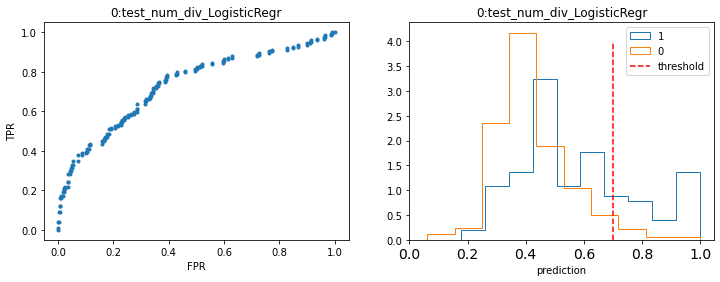

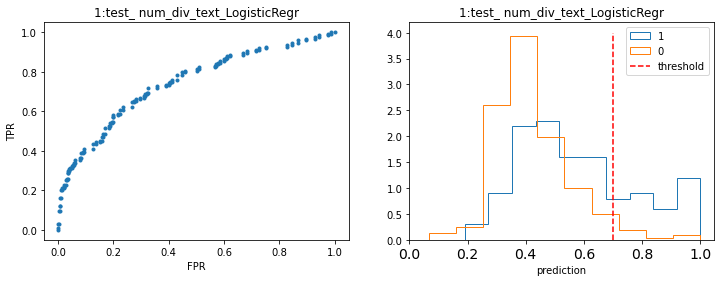

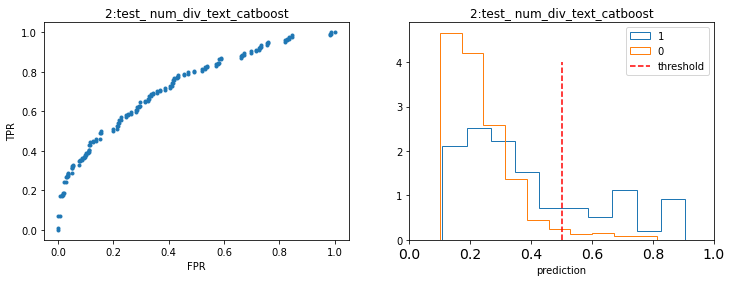

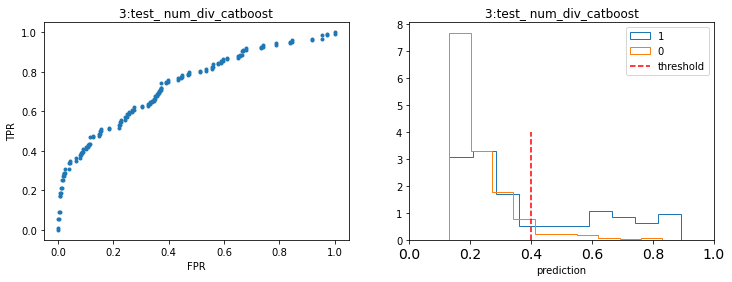

In [65]:
preds = results.predicted.values
name = results.model.values
thrs = results.thrs.values
for i in range(len(results)):
    plot(str(i) + ':' + name[i], preds[i], y_test, thrs[i])

# Вывод: 
Для прода выберем модель num_div_text_LogisticRegr с thrs=0.7

Параметры:
LogReg: {'warm_start': False, 'tol': 0.001, 'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 1000,
'intercept_scaling': 1, 'fit_intercept': False, 'dual': False, 'class_weight': 'balanced', 'C': 1}